In [1]:
import pandas as pd
import pickle
from zenml.client import Client
from pydantic import BaseModel
from github_search.ir.evaluator import InformationRetrievalEvaluatorConfig
import numpy as np

In [2]:
import matplotlib.pyplot as plt


In [3]:
def qqplot(a, b, n_qs=100):

    percs = np.linspace(0,100,n_qs)
    qn_a = np.percentile(a, percs)
    qn_b = np.percentile(b, percs)
    plt.plot(qn_a,qn_b, ls="", marker="o")
    plt.xlabel(a.name)
    plt.ylabel(b.name)

In [4]:
import pandas as pd

In [6]:
from tgutil.evaluation.preprocessing import EvalDFPreprocessor

preprocessor = EvalDFPreprocessor(id_col="repo", reference_text_col="true_tasks")

In [8]:
import json

In [9]:
with open("../github_search/pipelines/results/metrics_pipeline/ir_experiments_results.json", "rb") as f:
    ir_experiments_results = json.load(f)

In [10]:
from github_search.pipelines.metrics_comparison import MetricsExperimentResult, MetricComparator
result = MetricsExperimentResult(**ir_experiments_results[0])

In [11]:
class MetricsExperimentDFs(BaseModel):
    ir_config: InformationRetrievalEvaluatorConfig
    per_query_metrics_df: pd.DataFrame
    aggregate_metrics_df: pd.DataFrame
    generation_metrics_df: pd.DataFrame
    
    
    @classmethod
    def load_from_metrics_experiment_result(cls, result):
        return MetricsExperimentDFs(
            ir_config=result.ir_config,
            per_query_metrics_df=cls.load_df_from_records(result.per_query_metrics),
            aggregate_metrics_df=cls.load_df_from_records(result.aggregate_metrics).describe(),
            generation_metrics_df=cls.load_df_from_records(result.generation_metrics),
        )
        
    @classmethod
    def load_from_dicts(cls, result_dict):
        result = MetricsExperimentResult(**result_dict)
        return cls.load_from_metrics_experiment_result(result)
        
    @classmethod
    def load_df_from_records(cls, records):
        return pd.DataFrame.from_records(
            [
                {**rec, "generation": i}
                for i in records.keys()
                for rec in records[i]
            ]
        )
    
    class Config:
        arbitrary_types_allowed = True
        

In [12]:
raw_metrics_results_dfs = [MetricsExperimentDFs.load_from_dicts(result) for result in ir_experiments_results]

In [13]:
metric_results_dfs = sorted(raw_metrics_results_dfs, key=lambda mrdf: mrdf.aggregate_metrics_df["hit@10"]["mean"], reverse=True)

In [14]:
[mrdf.aggregate_metrics_df["hit@10"]["mean"] for mrdf in metric_results_dfs]

[0.33769063180827885,
 0.33769063180827885,
 0.33769063180827885,
 0.24727668845315903,
 0.24727668845315903,
 0.24727668845315903,
 0.210239651416122,
 0.210239651416122,
 0.210239651416122,
 0.20915032679738563,
 0.20915032679738563,
 0.20915032679738563,
 0.02178649237472767,
 0.02178649237472767,
 0.02178649237472767]

In [15]:
def get_all_ir_experiments_df(metric_results_dfs):
    all_experiments_ir_metrics_dfs = []
    for (i, mrdf) in enumerate(metric_results_dfs):
        df = mrdf.per_query_metrics_df.copy()
        df["tot_generation"] = df["generation"] + 3*i
        all_experiments_ir_metrics_dfs.append(df)

    return pd.concat(all_experiments_ir_metrics_dfs)

In [16]:
all_ir_experiments_df = get_all_ir_experiments_df(metric_results_dfs)

In [57]:
perq_query_generation_metrics = metric_results_dfs[0].generation_metrics_df.explode("true_tasks").rename({"true_tasks": "task"}, axis=1)
generation_metrics_df = metric_results_dfs[0].generation_metrics_df

In [181]:
def get_merged_metrics_df(ir_metrics_df, generation_metrics_df):
    per_task_generation_metrics_df = generation_metrics_df.explode(
        "true_tasks"
    ).rename(
        {"true_tasks": "task"}, axis=1
    ).groupby("task").mean()
   
    per_task_ir_metrics_df = ir_metrics_df.rename({"query": "task"}, axis=1).groupby("task").mean()
    
    return (
        per_task_ir_metrics_df
        .merge(per_task_generation_metrics_df, on="task")
    )


def get_metric_columns_and_rows(ir_metrics_df, generation_metrics_df):
    ir_metric_names = ir_metrics_df.select_dtypes(include="number").columns
    generation_metric_names = generation_metrics_df.select_dtypes(include="number").columns
    return ir_metric_names, generation_metric_names


def get_correlations_results(merged_metrics_df, columns=None, rows=None):
    corr_df = merged_metrics_df.corr(method="spearman")
    if not (columns is None or rows is None):
        columns = [col for col in columns if col in merged_metrics_df.columns]
        rows = [col for col in rows if col in merged_metrics_df.columns]
        return corr_df.loc[columns, rows]
    else:
        return corr_df

In [182]:
query_metrics_df = get_merged_metrics_df(all_ir_experiments_df, generation_metrics_df)

In [183]:
query_metrics_df["sentence_transformer_similarity"].describe()

count    306.000000
mean       0.235338
std        0.063305
min        0.050792
25%        0.199033
50%        0.237831
75%        0.269477
max        0.457401
Name: sentence_transformer_similarity, dtype: float64

In [184]:
corr_df = get_correlations_results(query_metrics_df, *get_metric_columns_and_rows(all_ir_experiments_df, generation_metrics_df))

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

In [186]:
_, generation_metric_cols = get_metric_columns_and_rows(all_ir_experiments_df, generation_metrics_df)
generation_corr_df = get_correlations_results(query_metrics_df, generation_metric_cols, generation_metric_cols)

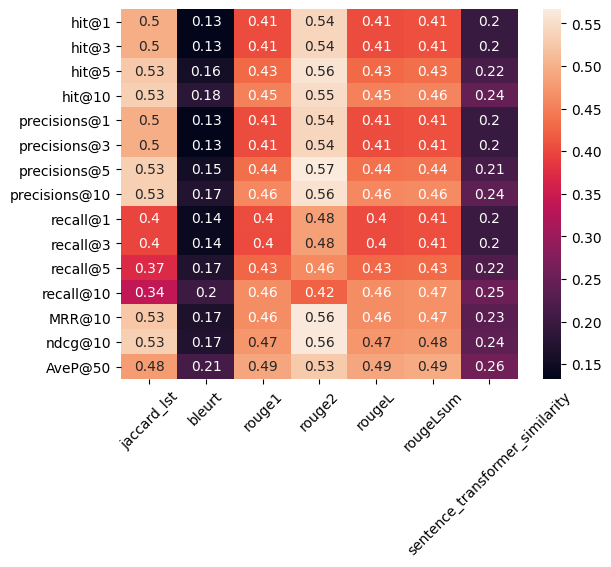

In [187]:
plot = sns.heatmap(corr_df.dropna().drop(columns=["edit_word"]), annot=True)
plt.setp(plot.get_xticklabels(), rotation=45)
plt.savefig("ir_vs_generation_metrics.png")

In [197]:
import statsmodels.api as sm

/home/kuba/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/home/kuba/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_1191599/2479605915.py:1 in <module>                                               │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_1191599/2479605915.py'                      │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/statsmodels/api.py:27 in <module>                  │
│                                                                                                  │
│   24 from .discrete.count_model import (ZeroInflatedPoisson,                                     │
│   25 │   │   │   │   │   │   │   │      ZeroInflatedGeneralizedPoisson,                          │
│   26 │   │   │   │   │   │   │   │      ZeroInflatedNegativeBinomialP)                           │
│ ❱ 27 from .tsa import api as tsa                                                                 │
│   28 from .duration.survfunc import SurvfuncRight                                                │
│   29 from .duration.hazard_regression import PHReg                                               │
│   30 from .imputation.mice import MICE, MICEData                                                 │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/statsmodels/tsa/api.py:31 in <module>              │
│                                                                                                  │
│   28 from .vector_ar.var_model import VAR                                                        │
│   29 from .vector_ar.vecm import VECM                                                            │
│   30 from .vector_ar.svar_model import SVAR                                                      │
│ ❱ 31 from .filters import api as filters                                                         │
│   32 from . import tsatools                                                                      │
│   33 from .tsatools import (add_trend, detrend, lagmat, lagmat2ds, add_lag)                      │
│   34 from . import interp                                                                        │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/statsmodels/tsa/filters/api.py:6 in <module>       │
│                                                                                                  │
│   3 from .bk_filter import bkfilter                                                              │
│   4 from .hp_filter import hpfilter                                                              │
│   5 from .cf_filter import cffilter                                                              │
│ ❱ 6 from .filtertools import miso_lfilter, convolution_filter, recursive_filter                  │
│   7                                                                                              │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/statsmodels/tsa/filters/filtertools.py:18 in       │
│ <module>                                                                                         │
│                                                                                                  │
│    15 import numpy as np                                                                         │
│    16 import scipy.fftpack as fft                                                                │
│    17 from scipy import signal                                                                   │
│ ❱  18 from scipy.signal.signaltools import _centered as tri

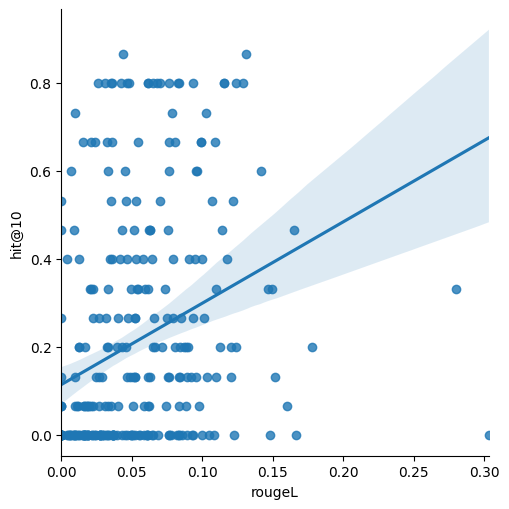

In [194]:
sns.lmplot(data=query_metrics_df, x="rougeL",y="hit@10")
plt.savefig("rouge_vs_hits.png")

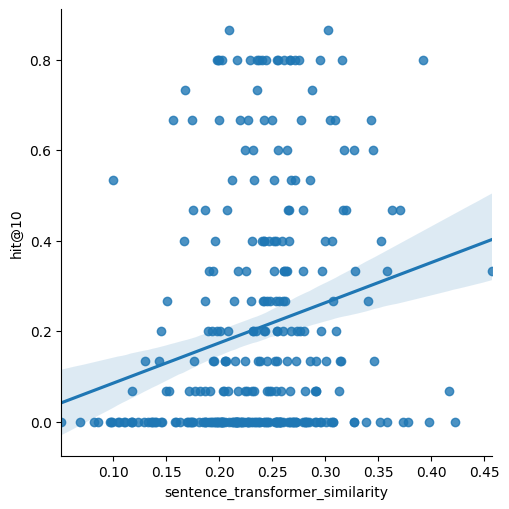

In [195]:
sns.lmplot(data=query_metrics_df, x="sentence_transformer_similarity",y="hit@10")
plt.savefig("sentence_transformer_vs_hit.png")

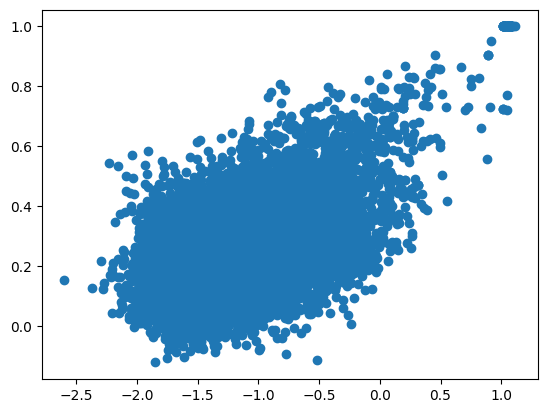

In [191]:
plt.scatter(generation_metrics_df["bleurt"], generation_metrics_df["sentence_transformer_similarity"])
plt.savefig("bleurt_vs_sst.png")

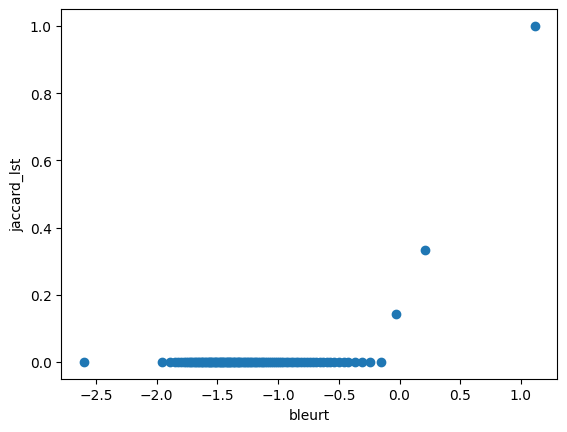

In [152]:
qqplot(generation_metrics_df["bleurt"], generation_metrics_df["jaccard_lst"])

In [ ]:
import seaborn as sns

In [ ]:
import statsmodels.api as sm

In [339]:
generation_metrics_df.corr(method="kendall")

,generation,edit_word,jaccard_lst,bleurt,rouge1,rouge2,rougeL,rougeLsum,sentence_transformer_similarity
generation,1.000000,0.007910,-0.010793,-0.011833,-0.004652,-0.012525,-0.004544,-0.004566,-0.006808
edit_word,0.007910,1.000000,-0.408782,-0.174926,-0.713887,-0.422740,-0.714561,-0.714610,-0.356686
jaccard_lst,-0.010793,-0.408782,1.000000,0.127702,0.320687,0.580293,0.320835,0.320765,0.188523
bleurt,-0.011833,-0.174926,0.127702,1.000000,0.155114,0.108631,0.154820,0.154734,0.344392
rouge1,-0.004652,-0.713887,0.320687,0.155114,1.000000,0.493651,0.996690,0.996564,0.432110
rouge2,-0.012525,-0.422740,0.580293,0.108631,0.493651,1.000000,0.494433,0.494360,0.270970
rougeL,-0.004544,-0.714561,0.320835,0.154820,0.996690,0.494433,1.000000,0.999258,0.431372
rougeLsum,-0.004566,-0.714610,0.320765,0.154734,0.996564,0.494360,0.999258,1.000000,0.431371
sentence_transformer_similarity,-0.006808,-0.356686,0.188523,0.344392,0.432110,0.270970,0.431372,0.431371,1.000000


In [334]:
sns.pairplot(generation_metrics_df)

Error in callback <function flush_figures at 0x7f9cb2fb6160> (for post_execute):


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/kuba/.local/lib/python3.8/site-packages/IPython/core/events.py:89 in trigger               │
│                                                                                                  │
│    86 │   │   """                                                                                │
│    87 │   │   for func in self.callbacks[event][:]:                                              │
│    88 │   │   │   try:                                                                           │
│ ❱  89 │   │   │   │   func(*args, **kwargs)                                                      │
│    90 │   │   │   except (Exception, KeyboardInterrupt):                                         │
│    91 │   │   │   │   print("Error in callback {} (for {}):".format(func, event))                │
│    92 │   │   │   │   self.shell.showtraceback()                                                 │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/matplotlib_inline/backend_inline.py:126 in         │
│ flush_figures                                                                                    │
│                                                                                                  │
│   123 │   │   if InlineBackend.instance().close_figures:                                         │
│   124 │   │   │   # ignore the tracking, just draw and close all figures                         │
│   125 │   │   │   try:                                                                           │
│ ❱ 126 │   │   │   │   return show(True)                                                          │
│   127 │   │   │   except Exception as e:                                                         │
│   128 │   │   │   │   # safely show traceback if in IPython, else raise                          │
│   129 │   │   │   │   ip = get_ipython()                                                         │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/matplotlib_inline/backend_inline.py:90 in show     │
│                                                                                                  │
│    87 │   │   close = InlineBackend.instance().close_figures                                     │
│    88 │   try:                                                                                   │
│    89 │   │   for figure_manager in Gcf.get_all_fig_managers():                                  │
│ ❱  90 │   │   │   display(                                                                       │
│    91 │   │   │   │   figure_manager.canvas.figure,                                              │
│    92 │   │   │   │   metadata=_fetch_figure_metadata(figure_manager.canvas.figure)              │
│    93 │   │   │   )                                                                              │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/IPython/core/display_functions.py:298 in display   │
│                                                                                                  │
│   295 │   │   if raw:                                                                            │
│   296 │   │   │   publish_display_data(data=obj, metadata=metadata, **kwargs)                    │
│   297 │   │   else:                                                                              │
│ ❱ 298 │   │   │   format_dict, md_dict = format(obj, include=include, exclude=exclude)           │
│   299 │   │   │   if not format_dict:                                                            │
│   300 │   │   │   │   # nothing to display (e.g. _ipython_d

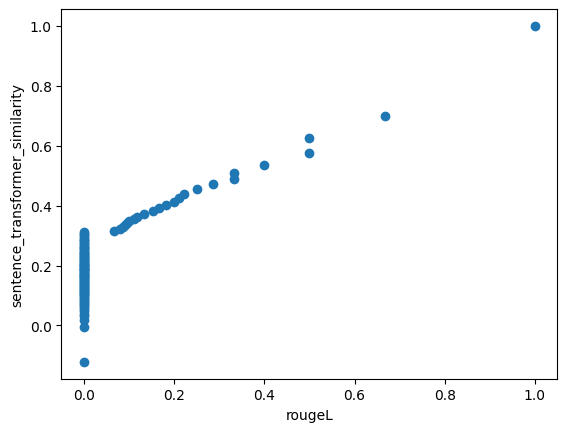

In [331]:
qqplot(generation_metrics_df["rougeL"], generation_metrics_df["sentence_transformer_similarity"])


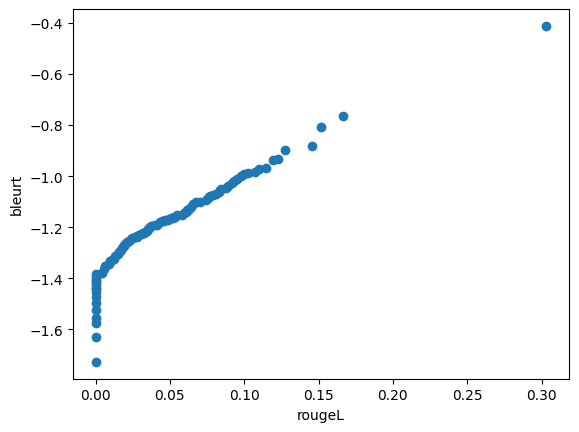

In [330]:
qqplot(query_metrics_df["rougeL"], query_metrics_df["bleurt"])

In [ ]:
qqplot(query_metrics_df[""], query_metrics_df["bleurt"])

In [140]:
metric_correlations_df = query_metrics_df.corr(method="kendall").loc[ir_metric_names, generation_metric_names]

In [141]:
metric_correlations_df

,edit_word,jaccard_lst,bleurt,rouge1,rouge2,rougeL,rougeLsum,sentence_transformer_similarity
hit@1,-0.236262,0.334060,0.016319,0.214897,0.248463,0.214897,0.214897,-0.062013
hit@3,-0.236262,0.334060,0.016319,0.214897,0.248463,0.214897,0.214897,-0.062013
hit@5,-0.335841,0.250111,0.034085,0.348438,0.353829,0.348438,0.348438,0.116714
hit@10,-0.308393,0.219698,0.009318,0.258513,0.236456,0.258513,0.258513,0.166693
precisions@1,-0.236262,0.334060,0.016319,0.214897,0.248463,0.214897,0.214897,-0.062013
precisions@3,-0.236262,0.334060,0.016319,0.214897,0.248463,0.214897,0.214897,-0.062013
precisions@5,-0.315434,0.300301,0.040745,0.318653,0.336881,0.318653,0.318653,0.071788
precisions@10,-0.301295,0.252594,0.029980,0.261994,0.254999,0.261994,0.261994,0.125542
recall@1,-0.225708,0.242682,0.006340,0.216927,0.242972,0.216927,0.216927,-0.050720
recall@3,-0.221807,0.228061,0.004200,0.213243,0.244742,0.213243,0.213243,-0.046203


In [145]:
import seaborn as sns

In [148]:
metric_correlations_df

,edit_word,jaccard_lst,bleurt,rouge1,rouge2,rougeL,rougeLsum,sentence_transformer_similarity
hit@1,-0.236262,0.334060,0.016319,0.214897,0.248463,0.214897,0.214897,-0.062013
hit@3,-0.236262,0.334060,0.016319,0.214897,0.248463,0.214897,0.214897,-0.062013
hit@5,-0.335841,0.250111,0.034085,0.348438,0.353829,0.348438,0.348438,0.116714
hit@10,-0.308393,0.219698,0.009318,0.258513,0.236456,0.258513,0.258513,0.166693
precisions@1,-0.236262,0.334060,0.016319,0.214897,0.248463,0.214897,0.214897,-0.062013
precisions@3,-0.236262,0.334060,0.016319,0.214897,0.248463,0.214897,0.214897,-0.062013
precisions@5,-0.315434,0.300301,0.040745,0.318653,0.336881,0.318653,0.318653,0.071788
precisions@10,-0.301295,0.252594,0.029980,0.261994,0.254999,0.261994,0.261994,0.125542
recall@1,-0.225708,0.242682,0.006340,0.216927,0.242972,0.216927,0.216927,-0.050720
recall@3,-0.221807,0.228061,0.004200,0.213243,0.244742,0.213243,0.213243,-0.046203


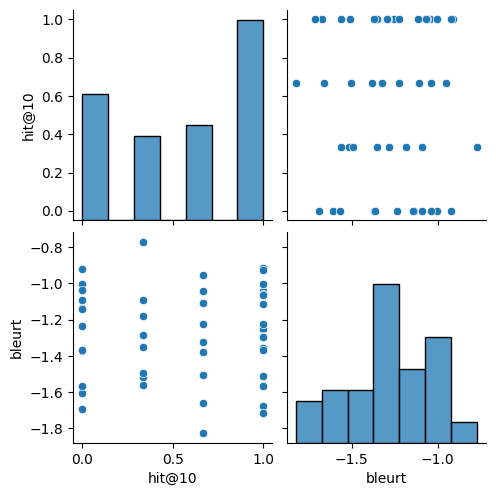

In [147]:
sns.pairplot(query_metrics_df[["hit@10", "bleurt"]])

In [143]:
query_metrics_df

,hit@1,hit@3,hit@5,hit@10,precisions@1,precisions@3,precisions@5,precisions@10,recall@1,recall@3,...,ndcg@10,AveP@50,edit_word,jaccard_lst,bleurt,rouge1,rouge2,rougeL,rougeLsum,sentence_transformer_similarity
task,,,,,,,,,,,,,,,,,,,,,
action localization,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,...,0.148667,0.099667,1.000000,0.000000,-1.514338,0.000000,0.000000,0.000000,0.000000,0.176434
action recognition,0.333333,0.333333,0.333333,0.666667,0.333333,0.333333,0.200000,0.133333,0.055667,0.166667,...,0.244000,0.207667,0.969697,0.000000,-1.660196,0.051282,0.000000,0.051282,0.051282,0.137086
adversarial defense,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.866667,0.500000,0.167000,0.500000,...,0.881667,0.874667,1.000000,0.000000,-1.253487,0.000000,0.000000,0.000000,0.000000,0.132740
anomaly detection,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.200000,0.100000,0.037000,0.111000,...,0.167000,0.117333,0.962418,0.000000,-1.286061,0.065163,0.027778,0.065163,0.065163,0.268547
automl,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.042667,1.000000,0.000000,-1.094195,0.011696,0.000000,0.011696,0.011696,0.163569
camera localization,0.000000,0.000000,0.333333,1.000000,0.000000,0.000000,0.133333,0.166667,0.000000,0.000000,...,0.274333,0.245667,1.000000,0.000000,-1.292159,0.000000,0.000000,0.000000,0.000000,0.329812
causal inference,0.000000,0.000000,0.333333,0.333333,0.000000,0.000000,0.133333,0.100000,0.000000,0.000000,...,0.118333,0.079667,1.000000,0.000000,-1.563080,0.000000,0.000000,0.000000,0.000000,0.055166
click through rate prediction,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,-1.371583,0.000000,0.000000,0.000000,0.000000,0.085393
combinatorial optimization,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000,0.133333,0.000000,0.000000,...,0.194000,0.139667,1.000000,0.000000,-1.380334,0.000000,0.000000,0.000000,0.000000,0.136089


In [134]:
#per_query_ir_metrics = per_query_ir_metrics.merge(evaluated_df, left_index=True, right_on="task")

ir_metric_names = per_query_ir_metrics.columns
generation_metric_names = evaluated_df.select_dtypes(include="number").columns
ir_vs_generation_metrics_df = query_metrics_df.corr(method="kendall").loc[
    ir_metric_names, generation_metric_names
]
aggregate_metrics = per_query_ir_metrics.describe()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_579882/2543061100.py:5 in <module>                                                │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_579882/2543061100.py'                       │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/pandas/core/indexing.py:961 in __getitem__         │
│                                                                                                  │
│    958 │   │   │   key = tuple(com.apply_if_callable(x, self.obj) for x in key)                  │
│    959 │   │   │   if self._is_scalar_access(key):                                               │
│    960 │   │   │   │   return self.obj._get_value(*key, takeable=self._takeable)                 │
│ ❱  961 │   │   │   return self._getitem_tuple(key)                                               │
│    962 │   │   else:                                                                             │
│    963 │   │   │   # we by definition only have the 0th axis                                     │
│    964 │   │   │   axis = self.axis or 0                                                         │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1147 in _getitem_tuple     │
│                                                                                                  │
│   1144 │   │                                                                                     │
│   1145 │   │   # ugly hack for GH #836                                                           │
│   1146 │   │   if self._multi_take_opportunity(tup):                                             │
│ ❱ 1147 │   │   │   return self._multi_take(tup)                                                  │
│   1148 │   │                                                                                     │
│   1149 │   │   return self._getitem_tuple_same_dim(tup)                                          │
│   1150                                                                                           │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1098 in _multi_take        │
│                                                                                                  │
│   1095 │   │   values: same type as the object being indexed                                     │
│   1096 │   │   """                                                                               │
│   1097 │   │   # GH 836                                                                          │
│ ❱ 1098 │   │   d = {                                                                             │
│   1099 │   │   │   axis: self._get_listlike_indexer(key, axis)                                   │
│   1100 │   │   │   for (key, axis) in zip(tup, self.obj._AXIS_ORDERS)                            │
│   1101 │   │   }                                                                                 │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1099 in <dictcomp>         │
│                                                                                                  │
│   1096 │   │   """                                                                               │
│   1097 │   │   # GH 836                                                                          │
│   1098 │   │   d = {                                       

In [ ]:
     {
            "ir_metrics_df": pd.DataFrame(aggregate_metrics),
            "ir_vs_generation_metrics_df": ir_vs_generation_metrics_df,
            "mean_generation_metrics": evaluated_df.mean().to_dict(),
            "mean_ir_metrics": aggregate_metrics.loc["mean"].to_dict(),
            "generation_metrics_summary": evaluated_df.describe(),
        }


In [42]:
MetricComparator().get_reported_metrics(per_query_ir_metrics=dfs.per_query_metrics_df.set_index("query"), evaluated_df=generation_metrics_df)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_579882/978708692.py:1 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_579882/978708692.py'                        │
│                                                                                                  │
│ /usr/local/lib/python3.8/dist-packages/pandera/decorators.py:265 in _wrapper                     │
│                                                                                                  │
│   262 │   │   │   raise TypeError(                                                               │
│   263 │   │   │   │   f"obj_getter is unrecognized type: {type(obj_getter)}"                     │
│   264 │   │   │   )                                                                              │
│ ❱ 265 │   │   return fn(*args, **kwargs)                                                         │
│   266 │                                                                                          │
│   267 │   return _wrapper                                                                        │
│   268                                                                                            │
│                                                                                                  │
│ /home/kuba/Projects/github_search/github_search/pipelines/metrics_comparison.py:114 in           │
│ get_reported_metrics                                                                             │
│                                                                                                  │
│   111 │   │   )                                                                                  │
│   112 │   │   ir_metric_names = per_query_ir_metrics.columns                                     │
│   113 │   │   generation_metric_names = evaluated_df.select_dtypes(include="number").columns     │
│ ❱ 114 │   │   ir_vs_generation_metrics_df = query_metrics_df.corr(method="kendall").loc[         │
│   115 │   │   │   ir_metric_names, generation_metric_names                                       │
│   116 │   │   ]                                                                                  │
│   117 │   │   aggregate_metrics = per_query_ir_metrics.describe()                                │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/pandas/core/indexing.py:961 in __getitem__         │
│                                                                                                  │
│    958 │   │   │   key = tuple(com.apply_if_callable(x, self.obj) for x in key)                  │
│    959 │   │   │   if self._is_scalar_access(key):                                               │
│    960 │   │   │   │   return self.obj._get_value(*key, takeable=self._takeable)                 │
│ ❱  961 │   │   │   return self._getitem_tuple(key)                                               │
│    962 │   │   else:                                                                             │
│    963 │   │   │   # we by definition only have the 0th axis                                     │
│    964 │   │   │   axis = self.axis or 0                                                         │
│                                                                                                  │
│ /home/kuba/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1147 in _getitem_tuple     │
│                                                                                                  │
│   1144 │   │                                                                                     │
│   1145 │   │   # ugly hack for GH #836                     

In [ ]:
dfs

In [ ]:
generation_metrics_df.merge(dfs.per_query_metrics_df, on=["query", "generation"]).groupby("query").apply(lambda df: df.mean()).corr()